##  Julien Clément and Johan Jobin       
### University of Fribourg               
### 2019                                 
###  Master's thesis        

In [3]:
# importation of modules
import nibabel as nib
import os
from dipy.align.imaffine import AffineMap
import numpy as np
import matplotlib.pyplot as plt
import sys
from PIL import Image
from PIL import ImageDraw
np.set_printoptions(threshold=sys.maxsize)

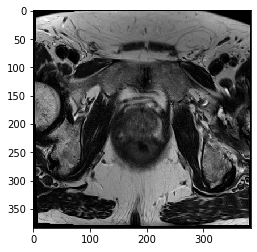

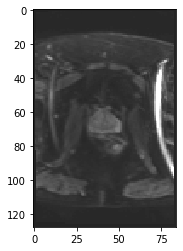

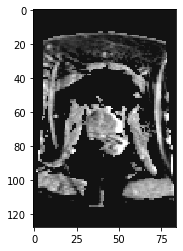

In [4]:
# Load original images and display them
t2 = np.load('ProstateX-0001_fid-1_mri-6-t2tsetra-76610_pos-157-186-10_slice-11_18.npy')
dwi = np.load('ProstateX-0001_fid-1_mri-7-ep2ddifftraDYNDISTMIX-61648_pos-34-63-10_slice-11_10.npy')
adc = np.load('ProstateX-0001_fid-1_mri-8-ep2ddifftraDYNDISTMIXADC-33954_pos-34-63-10_slice-11_9.npy')

plt.imshow(t2, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(dwi, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(adc, cmap='gray', vmin=0, vmax=255)
plt.show()

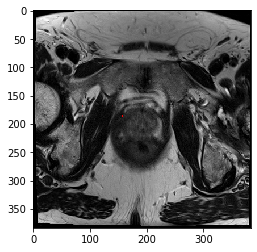

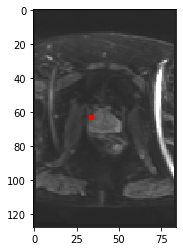

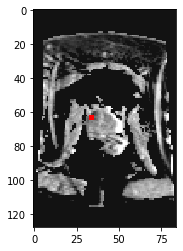

In [5]:
# Locate the lesion
# Convert arrays to PIL image
t2_img = Image.fromarray(t2)
dwi_img = Image.fromarray(dwi)
adc_img = Image.fromarray(adc)

# Get position of the lesion
t2_pos = (157, 186)
dwi_pos = (34, 63)
adc_pos = (34, 63)

# Convert image to RGB to add a red dot
t2_img_rgb = t2_img.convert('RGB')
dwi_img_rgb = dwi_img.convert('RGB')
adc_img_rgb = adc_img.convert('RGB')

# Add the red dot
t2_draw = ImageDraw.Draw(t2_img_rgb)
t2_draw.ellipse( (t2_pos[0]-1, t2_pos[1]-1, t2_pos[0]+1, t2_pos[1]+1), fill=(255,0,0,255))

dwi_draw = ImageDraw.Draw(dwi_img_rgb)
dwi_draw.ellipse((dwi_pos[0]-1, dwi_pos[1]-1, dwi_pos[0]+1, dwi_pos[1]+1), fill=(255,0,0,255))

adc_draw = ImageDraw.Draw(adc_img_rgb)
adc_draw.ellipse((adc_pos[0]-1, adc_pos[1]-1, adc_pos[0]+1, adc_pos[1]+1), fill=(255,0,0,255))

# Plot images
plt.imshow(t2_img_rgb)
plt.show()
plt.imshow(dwi_img_rgb)
plt.show()
plt.imshow(adc_img_rgb)
plt.show()

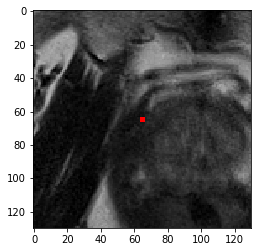

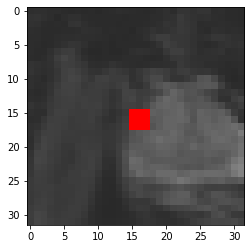

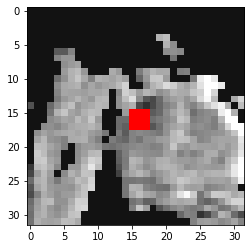

In [6]:
# Use "VoxelSpacing" from the CSV file to crop the same amount of tissue on each image
t2_voxel_spacing = np.array([0.5,0.5]) # (0.5,0.5,3) -> only working on 1 slice, so we can omit the third dimension
dwi_voxel_spacing = np.array([2,2]) # (2,2,3)
adc_voxel_spacing = np.array([2,2]) # (2,2,3)

# The patch size from the biggest image is fixed. Others must be computed
t2_patch_size = np.array([65,65])

# DWI resolution < T2 resolution. Hence, we need less dwi pixels to get the same amount of tissue as on the t2
dwi_patch_size = t2_patch_size // (dwi_voxel_spacing / t2_voxel_spacing) # [16,16]
adc_patch_size = t2_patch_size // (adc_voxel_spacing / t2_voxel_spacing)

# Crop the images
t2_cropped = t2_img_rgb.crop((t2_pos[0] - t2_patch_size[0], t2_pos[1] - t2_patch_size[1], t2_pos[0] + t2_patch_size[0], t2_pos[1] + t2_patch_size[1]))
dwi_cropped = dwi_img_rgb.crop((dwi_pos[0] - dwi_patch_size[0], dwi_pos[1] - dwi_patch_size[1], dwi_pos[0] + dwi_patch_size[0], dwi_pos[1] + dwi_patch_size[1]))
adc_cropped = adc_img_rgb.crop((adc_pos[0] - adc_patch_size[0], adc_pos[1] - adc_patch_size[1], adc_pos[0] + adc_patch_size[0], adc_pos[1] + adc_patch_size[1]))

# Plot the cropped images
plt.imshow(t2_cropped)
plt.show()
plt.imshow(dwi_cropped)
plt.show()
plt.imshow(adc_cropped)
plt.show()

In [7]:
# At this point, the amount of tissue on the three images is the same. 
# However, their resolution is not the same, which is problematic since we want to stack 
# them as input to the NN. The pixel (i,j) on the three images should represent the same information.
print(f'T2 size {t2_cropped.size}')
print(f'DWI size {dwi_cropped.size}')
print(f'ADC size {adc_cropped.size}')

T2 size (130, 130)
DWI size (32, 32)
ADC size (32, 32)


T2 size (130, 130)
DWI size (130, 130)
ADC size (130, 130)


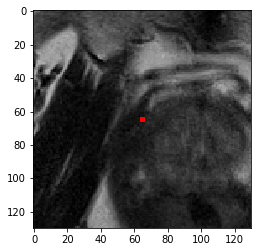

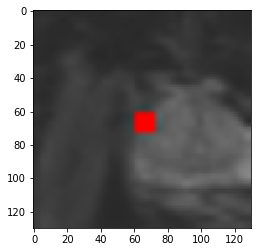

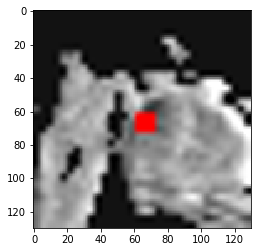

In [42]:
# Resolution of t2 images is always higher than dwi and adc. So, dwi and adc must be upscaled.
t2_cropped_resize = t2_cropped
dwi_cropped_resize = dwi_cropped.resize(t2_cropped.size, Image.BICUBIC)
adc_cropped_resize = adc_cropped.resize(t2_cropped.size, Image.BICUBIC)

# Check that the dimensions match.
print(f'T2 size {t2_cropped_resize.size}')
print(f'DWI size {dwi_cropped_resize.size}')
print(f'ADC size {adc_cropped_resize.size}')

plt.imshow(t2_cropped_resize)
plt.show()
plt.imshow(dwi_cropped_resize)
plt.show()
plt.imshow(adc_cropped_resize)
plt.show()